<AxesSubplot:xlabel='target'>

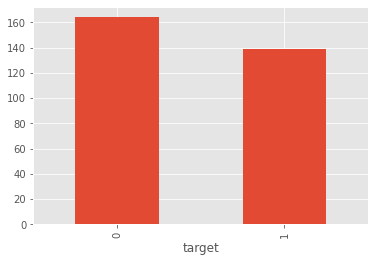

In [5]:
import scikitplot as skplt
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve, cross_validate, StratifiedShuffleSplit,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import sys
from collections import Counter

np.set_printoptions(suppress=True, threshold=sys.maxsize)
plt.style.use('ggplot')
# Using panda.io to read the dataset
unprocessed_data_X = pd.read_csv("heartdisease300.csv")
unprocessed_data_y = unprocessed_data_X.loc[:, "target"]
unprocessed_data_X.pivot_table(index="target", aggfunc='size').plot(kind='bar')


In [ ]:
# Feature Selection using a chi-squared scoring function
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
feature_selection = SelectKBest(chi2, k=13)
feature_selection_data = feature_selection.fit_transform(
    unprocessed_data_X, unprocessed_data_y)
processed_data_X = feature_selection_data[:, :-1]
processed_data_Y = feature_selection_data[:, 12]
# Hyperparameters: score_func - chi2
# This feature had the lowest chi2 scores and will be excluded:
# fasting blood sugar > 120 mg/dl

In [ ]:
# SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote_processed_data_X, smote_processed_data_Y = SMOTE(
    k_neighbors=10, random_state=2).fit_resample(processed_data_X, processed_data_Y)
# Hyperparameters: sampling_strategy - auto = resampling only the minority class
# k_neighbors - default = 5
# ??? new entries were created by SMOTE to oversample the minority

In [ ]:
# 70%/30% Training Test Split
processed_train_X, processed_test_X, processed_train_Y, processed_test_Y = train_test_split(
    processed_data_X, processed_data_Y, test_size=0.3, random_state=1)
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(
    smote_processed_data_X, smote_processed_data_Y, test_size=0.3, random_state=1)
# Hyperparameters: test_size - 30
# train_size - 70
# shuffle default = True

smote_processed_data_X.pivot_table(index=smote_processed_data_Y, aggfunc='size').plot(kind='bar')


In [ ]:
# Scatterplot for unprocessed data
# print(unprocessed_data_X)
g1 = unprocessed_data_X.loc[:, "age":"target"]
plt.scatter('trestbps', 'chol', data=g1)

# Scatterplot for SMOTE treated data
# Convert SMOTE-treated data numpy array to DataFrame to use .loc
smoteDF = pd.DataFrame(smote_processed_data_X)
smoteDF.to_csv("SMOTEData.csv")

# print(smoteDF)
g2 = smoteDF.loc[1025:1051, :]  # New data from SMOTE
# print (g2)
smoteDF.plot(x=3, y=4, kind='scatter')




In [ ]:
# RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

random_forest = RandomForestClassifier(bootstrap=True, max_depth=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_weight_fraction_leaf=0.0,
                                       n_estimators=50, criterion='log_loss', max_features='log2', min_samples_split=2, min_samples_leaf=1, random_state=50)

# RF w/ SMOTE
random_forest_smote = random_forest.fit(smote_train_X, smote_train_Y)

print('---RANDOM FOREST---')
print('Random Forest w/ SMOTE Training Set Accuracy: ', end="")
print(random_forest_smote.score(smote_train_X, smote_train_Y))
print('Random Forest w/ SMOTE Test Set Accuracy: ', end="")
print(random_forest_smote.score(smote_test_X, smote_test_Y))

# RF w/o SMOTE
random_forest_processed = random_forest.fit( processed_train_X, processed_train_Y)
print('Random Forest w/o SMOTE Training Accuracy: ', end="")
print(random_forest_processed.score(smote_train_X, smote_train_Y))
print('Random Forest w/o SMOTE Test Set Accuracy: ', end="")
print(random_forest_processed.score(processed_test_X, processed_test_Y))

random_forest_smote_predictions = random_forest_smote.predict(smote_test_X)
random_forest_processed_predictions = random_forest_processed.predict(processed_test_X)

# Paste RF Confusion Matrix Graph Code Here

# Scores for Statistics

print("\n")
print("Random Forest w/ SMOTE Classification Report")
print(classification_report(smote_test_Y, random_forest_smote_predictions))
print("Random Forest w/o SMOTE Classification Report")
print(classification_report(processed_test_Y, random_forest_processed_predictions))

# Paste RF Learning Curve Graph Code Here

In [ ]:
#gridsearch for SVM
Cs = [1, 10 ,100, 1000, 10000]
gammas = [0.001, 0.01, 0.0001, 0.00001,0.000001]
param_grid = {'C': Cs, 'gamma' : gammas}
svm = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=10)

In [ ]:
#SVM
# SVM w/ SMOTE
svm_smote=svm.fit(smote_train_X, smote_train_Y)
svm_predicted_smote = svm_smote.predict(smote_test_X)
svmSmote_acc_score = accuracy_score(smote_test_Y, svm_predicted_smote)
print('---SUPPORT VECTOR MACHINE---')
# print('SVM w/ SMOTE Test Set Accuracy: ', end="")
# print(svm_smote.score(smote_test_X, smote_test_Y))
# print('SVM w/ SMOTE Training Set Accuracy: ', end="")
# print(svm_smote.score(smote_train_X, smote_train_Y))
print("Accuracy of Support Vector Classifier w/SMOTE:",svmSmote_acc_score*100,'\n')

# SVM w/o SMOTE
svm_nosmote = svm.fit(processed_train_X, processed_train_Y)
svm_predicted_nosmote = svm_nosmote.predict(processed_test_X)
svmNoSmote_acc_score = accuracy_score(processed_test_Y, svm_predicted_nosmote)
# print('SVM w/o SMOTE Test Set Accuracy: ', end="")
# print(svm_nosmote.score(processed_test_X, processed_test_Y))
# print('SVM w/o SMOTE Training Set Accuracy: ', end="")
# print(svm_nosmote.score(processed_train_X, processed_train_Y))
print("Accuracy of Support Vector Classifier w/o SMOTE:",svmNoSmote_acc_score*100,'\n')

print()

#confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
svc_conf_matrix_nosmote = confusion_matrix(processed_test_Y,svm_predicted_nosmote)
print(svc_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
svc_conf_matrix_smote = confusion_matrix(smote_test_Y,svm_predicted_smote)
print(svc_conf_matrix_smote)

#scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y,svm_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y,svm_predicted_smote))



In [ ]:
#TODO: MV

# estimators for ensembling MV
estimators = [('RandomForest', random_forest), ('SVM', svm)]
ensemble_smote = VotingClassifier(estimators, voting='hard', weights=[
                                  1, 1])  # hard voting, because we are doing MV
ensemble_smote.fit(smote_test_X, smote_test_Y)

results_smote = model_selection.cross_val_score(
    ensemble_smote, smote_test_X, smote_test_Y, scoring='accuracy')
print()
print("Validation accuracy for Ensembling w/ SMOTE: ", end="")
print(results_smote.mean())

# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters

params = {'voting': ['soft', 'hard'],
          'weights': [(1, 1)]}

grid_smote = GridSearchCV(estimator=ensemble_smote, param_grid=params, cv=2)

grid_smote.fit(smote_train_X, smote_train_Y)
print("Best parameters for Ensembling + SMOTE: ", end="")
print(grid_smote.best_params_)

#{'voting': 'hard', 'weights': (1, 1)}

# validation graph
param_range = np.arange(0, 10, 1, dtype=int)

train_scores, test_scores = validation_curve(
    ensemble_smote,
    smote_train_X,
    smote_train_Y,
    param_name="n_jobs",
    param_range=param_range,
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,
         label="njobs_train")
plt.plot(param_range, test_scores_mean, label="njobs_validation")
plt.title("MV SMOTE-treated Validation Curves")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

ensemble_proc = VotingClassifier(estimators, voting='hard', weights=[
                                 1, 1])  # hard voting, because we are doing MV
ensemble_proc.fit(processed_test_X, processed_test_Y)

results_proc = model_selection.cross_val_score(
    ensemble_proc, processed_test_X, processed_test_Y, scoring='accuracy')
print()
print("Validation accuracy for Ensembling w/o SMOTE: ", end="")
print(results_proc.mean())


# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters
params = {'voting': ['soft', 'hard'],
          'weights': [(1, 1)]}

grid_proc = GridSearchCV(estimator=ensemble_proc, param_grid=params, cv=2)

grid_proc.fit(processed_train_X, processed_train_Y)
print("Best parameters for Ensembling w/o SMOTE: ", end="")
print(grid_proc.best_params_)

#{'voting': 'hard', 'weights': (1, 1)}

param_range = np.arange(1, 10, 1, dtype=int)
train_scores, test_scores = validation_curve(
    ensemble_proc,
    processed_test_X,
    processed_test_Y,
    param_name="n_jobs",
    param_range=param_range,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="train", color="blue")
plt.plot(param_range, test_scores_mean, label="test", color="red")

plt.legend()
plt.show()
y_pred = ensemble_proc.predict(processed_test_X)
print(classification_report(processed_test_Y, y_pred))

skplt.metrics.plot_confusion_matrix(processed_test_Y, y_pred, figsize=(10, 8))
plt.show()
# confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
y_proc_pred = ensemble_proc.predict(processed_test_X)
ensemble_matrix_proc = confusion_matrix(processed_test_Y, y_proc_pred)
print(ensemble_matrix_proc)
print("\n")
print("with smote")
print("\n")
y_smote_pred = ensemble_smote.predict(smote_test_X)
ensemble_matrix_smote = confusion_matrix(smote_test_Y, y_smote_pred)
print(ensemble_matrix_smote)

# scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y, y_proc_pred))
print("with smote")
print(classification_report(smote_test_Y, y_smote_pred))

# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# # Refer to MV documentation for possible parameter values
